### Imports

In [168]:
# Imports
from langchain_openai import ChatOpenAI
from typing import List, Annotated, TypedDict, Dict, Optional
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, HumanMessage
from pydantic import BaseModel, Field
from collections import Counter
from dotenv import load_dotenv
import unicodedata
import os
import re

print("All Imports Successful")

All Imports Successful


### Defining State Schemas

In [169]:
# All The State Schemas
class UserProfile(TypedDict):
    profile_description: Optional[str]
    expertise: Optional[str]
    target_audience: Optional[str]

class AuditorOutput(TypedDict):
    professional_niche: Optional[str]
    content_theme: Optional[str]
    tone: Optional[str]

class AnalystOutput(TypedDict):
    hook_patterns: Optional[List[str]]
    post_structures: Optional[List[str]]
    cta_styles: Optional[List[str]]
    keywords: Optional[List[str]]

class State(TypedDict):
    user_profile: UserProfile
    auditor_output: Optional[AuditorOutput]
    analyst_output: Optional[AnalystOutput]
    creator_output: Optional[str]


### Memory

In [170]:
class WeekMemory:
    def __init__(self):
        self.used_hook_types = set()
        self.used_structures = set()
        self.used_focused_angles = set()
    
    def marked_used(self, hook_type: str, structure: str, focus: str):
        self.used_hook_types.add(hook_type)
        self.used_structures.add(structure)
        self.used_focused_angles.add(focus)

ALLOWED_HOOK_TYPES = [
    "question",
    "bold claim",
    "reference-based",
    "consequence framing",
    "reflective synthesis",
]

ALLOWED_STRUCTURES = [
    "explanatory",
    "argumentative",
    "interview / evidence",
    "list-based or analysis",
    "explanatory synthesis",
]

ALLOWED_FOCUS = [
    "big-picture provocation",
    "theoretical grounding",
    "research and experiments",
    "applications and implications",
    "future outlook",
]

def select_strict(option: str, used: set, allowed: list) -> str:
    if option not in used:
        return option
    
    for alt in allowed:
        if alt not in used:
            return alt
    
    return option

### Loading the LLM

In [171]:
# Loading LLM
load_dotenv()
def groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0, max_tokens=2000,
    )
llm = groq_llm()

### Data For the Vector store and Document Loading

In [172]:
from langchain_core.documents import Document

linkedin_posts = [
    """Can STRATEGY learn anything from QUANTUM MECHANICS?

    Quantum mechanics offers valuable insights for strategic leadership in today's complex and uncertain business environment. Here's how we can apply quantum principles to enhance our leadership approach:

    1]. EMBRACING UNCERTAINTY AND POSSIBILITY

    In quantum mechanics, particles exist in multiple states simultaneously until observed. Similarly, strategic leaders must embrace uncertainty and consider multiple possibilities. Instead of rigid, deterministic planning, we should:

    - Envision multiple potential outcomes for any situation
    - Explore diverse approaches with input from various stakeholders
    - Maintain flexibility to pivot as circumstances evolve

    This "superposition" mindset allows us to thrive on uncertainty and foster innovation at the "edge of chaos".

    2]. THE POWER OF OBSERVATION AND INTENTION

    Just as observing quantum particles affects their state, a leader's focus shapes organizational reality. We must be mindful of our "observer effect" by:

    - Cultivating awareness of our perceptual biases
    - Intentionally creating a positive organizational culture
    - Balancing focus between efficiency (exploiting) and effectiveness (exploring)

    Our attention and expectations have ripple effects throughout the organization.

    3]. INTERCONNECTEDNESS AND EMERGENCE

    Quantum entanglement demonstrates the interconnected nature of particles. In leadership, this translates to:

    - Fostering strong relationships and networks within teams
    - Recognizing that small actions can have far-reaching impacts
    - Allowing for bottom-up, self-organizing structures to emerge

    By cultivating a high "connectivity quotient," we can create teams that perform beyond the sum of their parts.

    4]. ADAPTING TO COMPLEXITY

    Quantum uncertainty challenges traditional, linear planning. To lead effectively in complex systems:

    - Adopt an adaptive, learning-oriented approach to strategy
    - Encourage experimentation and "quantum tunneling" to overcome barriers
    - Focus on creating conditions for innovation rather than rigid objectives.

    By embracing these quantum principles, we can develop a more nuanced, flexible, and effective approach to strategic leadership in our rapidly changing world.
    """,
    """Quantum Mechanics is the most inspiring and exciting Physics practice, mostly because of entanglement (ok, per my own experience, the math is also extremely challenging). 

    Olimpia Lombardi has a compelling argument in her recent article: 

    Quantum physics doesn’t just alter our mathematical descriptions—it dismantles our entire notion of “things.” At the most fundamental level, the quantum realm reveals not independent objects, but an undivided whole, with no distinct individuality or stable identities .

    This isn’t merely academic musing. It underscores a profound philosophical lesson:
    • Physics as Philosophy at Its Core: Quantum mechanics challenges our foundational assumptions. What we consider discrete objects may simply be emergent abstractions—useful at our scale but not with real substance at the quantum level.
    • Reality Is More Fluid Than We Think: The absence of individuality in the quantum world reminds us that reality is deeply interconnected. Like a tapestry, every thread is part of a coherent whole—not isolated patches.
    • Science as Ontological Inquiry: Physics isn’t just about predicting outcomes; it interrogates what is. Quantum mechanics forces us to reconsider identity, separateness, and even the nature of existence itself.

    Why this matters to all of us

    Whether you’re leading a team, designing systems, or shaping narratives—quantum mechanics teaches a vital lesson: our categories and labels aren’t the final word. In our interconnected world, reducing complexity to simplistic “things” blinds us to the deeper structure of reality.

    Let this remind us: both science and leadership call us to look beyond the visible, question foundational assumptions, and embrace the richness of interrelation over atomized certainty.

    hashtag
    #science 
    hashtag
    #physics 
    hashtag
    #meta
    """,
    """
    Is our universe truly local?

    Particle physics successfully blends quantum mechanics and special relativity, yielding a picture of reality permeated by interacting, evolving, and fluctuating fields. One of the most fascinating features of this theoretical framework is its ability to incorporate the principle of locality: the idea, already dear to people like Newton, that ‘physical entities only influence what is close to them’. 

    Yet, certain aspects of quantum mechanics seem to be in tension –if not in direct contradiction– with a strong notion of locality. How can we overcome this impasse? Are our models consistent? What do they ultimately tell us about the world? 

    I discussed this with Eduardo Martin-Martinez, associate professor of mathematical physics at the University of Waterloo. There, he studies the interaction between relativistic quantum information, measurement theory, and quantum gravity. Don't miss my new interview for the International Society for Quantum Gravity channel!

    https://lnkd.in/eRF3-i7Y

    hashtag
    #quantum 
    hashtag
    #spacetime 
    hashtag
    #entanglement 
    hashtag
    #science 
    hashtag
    #communication
    """,
    """New research into quantum physics suggests death may not be the end, but a shift in consciousness within a multiverse shaped by the observer.

    That's the bold proposition of biocentrism, a scientific theory suggesting that life and consciousness are not accidental byproducts of the universe, but rather its very foundation.

    Proponents argue that what we perceive as death is only a transition-a change in our conscious experience -within a reality shaped by the observer. Drawing on quantum physics and decades of experiments, the theory challenges our basic understanding of time, space, and existence itself.

    Phenomena like entanglement, the observer effect, and retrocausality point to a universe where consciousness influences outcomes, blurring the line between what's "real" and what's observed.

    Experiments in quantum mechanics, from photons predicting future conditions to particles seemingly altering the past, bolster the idea that reality is deeply linked to perception. These results suggest that our sense of a fixed external world may be misleading. If consciousness defines reality, then the end of physical life may not equate to the end of existence.

    Instead, life might persist in a dimension beyond time- within an interconnected multiverse where all possibilities coexist. Far from science fiction, this view is reshaping how some scientists and thinkers

    understand mortality, hinting at a universe where death isn't final but part of a broader, ongoing continuum of

    awareness.
    """,
    """Flaminia Giacomini explores how to extend the principle of general covariance into the quantum domain, focusing on the role of quantum reference frames. In general relativity, physics is formulated without any fixed background: all coordinate systems are equally valid, and no frame is privileged. Quantum theory, on the other hand, assumes an external classical frame.

    Giacomini and collaborators have developed a framework where reference frames themselves are treated as quantum systems. These can be in superposition, entangled, or even swapped dynamically. Transformations between them generalize classical coordinate changes, allowing descriptions of physics that remain fully relational, even in quantum contexts. This could be a key step toward a background-independent quantum theory of gravity.

    This video is part of the International Society for Quantum Gravity ISQG outreach initiative, bringing together researchers from different backgrounds to tackle one of the biggest open questions in physics: what is the microscopic, quantum nature of space-time?

    Want to hear more? The full interview with Flaminia Giacomini is now available on the ISQG YouTube channel.

    Can we make quantum theory compatible with the relational foundations of general relativity? Let’s discuss in the comments!

    hashtag
    #Physics 
    hashtag
    #QuantumGravity 
    hashtag
    #Spacetime
    """
]
documents = [
    Document(
        page_content=post,
        metadata={"source": "linkedin"},
    )
    for post in linkedin_posts
]

print(f"Loaded {len(documents)} documents")
print(f"Documents are as follows: {documents}")

Loaded 5 documents
Documents are as follows: [Document(metadata={'source': 'linkedin'}, page_content='Can STRATEGY learn anything from QUANTUM MECHANICS?\n\n    Quantum mechanics offers valuable insights for strategic leadership in today\'s complex and uncertain business environment. Here\'s how we can apply quantum principles to enhance our leadership approach:\n\n    1]. EMBRACING UNCERTAINTY AND POSSIBILITY\n\n    In quantum mechanics, particles exist in multiple states simultaneously until observed. Similarly, strategic leaders must embrace uncertainty and consider multiple possibilities. Instead of rigid, deterministic planning, we should:\n\n    - Envision multiple potential outcomes for any situation\n    - Explore diverse approaches with input from various stakeholders\n    - Maintain flexibility to pivot as circumstances evolve\n\n    This "superposition" mindset allows us to thrive on uncertainty and foster innovation at the "edge of chaos".\n\n    2]. THE POWER OF OBSERVATIO

### Storing data to the Vector store and embedding

In [173]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

vectorstore = FAISS.from_documents(
    documents=documents,
    embedding=embeddings
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

print("Vector Store ready")

Vector Store ready


### Defining The Nodes

In [174]:
# Functions/Nodes
def auditor_agent(state: State) -> Dict[str, Optional[AuditorOutput]]:
    """
    Auditor Agent:
    - Reads: user_profile
    - Writes: auditor_output
    - Does NOT generate posts or use RAG
    """
    user_profile = state["user_profile"]

    prompt = f"""
    You are a LinkedIn content strategy auditor.

    Your task is to analyze the user profile and make strategic decisions.
    Do NOT write posts. Do NOT explain your reasoning.

    User Profile:
    - Description: {user_profile.get("profile_description")}
    - Expertise: {user_profile.get("expertise")}
    - Target Audience: {user_profile.get("target_audience")}

    Return the strategy STRICTLY in the following format.
    Do NOT add explanations or extra text.

    Professional Niche:
    <one short line>

    Content Theme:
    <one short line>

    Tone:
    <one short line>
    """
    response = llm.invoke(prompt)

    lines = response.content.split("\n")

    parsed = {}
    for line in lines:
        if ":" in line:
            key, value = line.split(":", 1)
            parsed[key.strip().lower()] = value.strip()

    auditor_output: AuditorOutput = {
        "professional_niche": parsed.get("professional niche"),
        "content_theme": parsed.get("content theme"),
        "tone": parsed.get("tone"),
        }
    
    return {"auditor_output": auditor_output}

def analyst_agent(state: State) -> Dict[str, Optional[AnalystOutput]]:
    """
    Analyst Agent:
    - Reads: auditor_output
    - Writes: analyst_output
    - Extracts winning patterns (hooks, structures, CTAs, keywords)
    - Does NOT generate posts or modify strategy
    """
    auditor_output = state["auditor_output"]

    query = f"""
    High-performing LinkedIn posts about {auditor_output['professional_niche']}
    written in a {auditor_output['tone']} tone.
    """

    retrieved_docs = retriever.invoke(query)

    hooks = [] # Winning Pattern 1: Extracting Hooks from the Document
    structures = [] # Winning Pattern 2: Extracting Post Structures from the Document
    ctas = [] # Winning Pattern 3: Extracting Call To Actions (CTAs) from the Document
    all_text = [] # Winning Pattern 3: Keywords from the Document

    for doc in retrieved_docs:
        text = doc.page_content.strip()
        all_text.append(text.lower())

        paragraphs = [p.strip() for p in text.split("\n\n") if p.strip()]
        # Hook Extraction
        hooks.append(paragraphs[0])

        # CTA extraction
        ctas.append(paragraphs[-1])

        # Post Structure Determination
        body_text = "\n\n".join(paragraphs[1:-1]).lower()

        if any(token in body_text for token in ["1]", "1.", "- "]):
            structure = "List-based breakdown"
        elif any(token in body_text for token in ["interview", "i discussed", "i spoke with"]):
            structure = "Interview / discussion"
        elif any(token in body_text for token in ["therefore", "this suggests", "this implies", "because"]):
            structure = "Argumentative analysis"
        else:
            structure = "Explanatory essay"
        
        structures.append(structure)

        # Keyword extraction
        combined_text = " ".join(all_text)

        normalized_text = unicodedata.normalize("NFKD", combined_text)
        normalized_text = normalized_text.encode("ascii", "ignore").decode("ascii")

        clean_text = re.sub(r"[^a-zA-Z]", " ", normalized_text)

        clean_text = clean_text.lower()
        tokens = clean_text.split()
        
        stopwords = {
        "that", "this", "with", "from", "your", "have", "what",
        "when", "where", "which", "their", "about", "would",
        "could", "there", "these", "those", "while", "being",
        "into", "than", "then", "them", "they", "also"
        }
        platform_words = {
        "hashtag", "link", "comment", "comments", "channel",
        "youtube", "linkedin", "post", "posts"
        }

        stopwords = stopwords.union(platform_words)
        keywords = [
            word for word, _ in Counter(tokens).most_common(20)
            if len(word) > 3 and word not in stopwords
        ]

    analyst_output: AnalystOutput = {
        "hook_patterns": hooks,
        "post_structures": structures,
        "cta_styles": ctas,
        "keywords": keywords,
    }
    
    return {"analyst_output": analyst_output}

def five_day_planner():
    """
    Deterministic 5-day LinkedIn content plan (MVP)
    Returns a list of day-specific instructions for the Creator.
    """
    return [
        {
            "day": 1,
            "hook_type": "question",
            "structure": "explanatory",
            "focus": "big-picture provocation",
            "cta_intent": "invite discussion",
        },
        {
            "day": 2,
            "hook_type": "bold claim",
            "structure": "argumentative",
            "focus": "theoretical grounding",
            "cta_intent": "continue series",
        },
        {
            "day": 3,
            "hook_type": "reference-based",
            "structure": "interview / evidence",
            "focus": "research and experiments",
            "cta_intent": "ask for perspective",
        },
        {
            "day": 4,
            "hook_type": "consequence framing",
            "structure": "list-based or analysis",
            "focus": "applications and implications",
            "cta_intent": "encourage reflection",
        },
        {
            "day": 5,
            "hook_type": "reflective synthesis",
            "structure": "explanatory synthesis",
            "focus": "future outlook",
            "cta_intent": "wrap up and preview",
        },
    ]

def cta_instruction_block(plan: dict) -> str:
    """
    Converts CTA intent + day into explicit instructions for the Creator.
    This enforces sequence-aware CTA behavior.
    """
    day = plan["day"]
    intent = plan["cta_intent"]

    if day == 1:
        return """
        CTA RULES:
        - Invite discussion
        - Explicitly mention that this is the start of a series
        - Mention that the topic will be continued tomorrow
        - Keep CTA to 1–2 lines
        """

    if day == 2:
        return """
        CTA RULES:
        - Explicitly reference yesterday’s post
        - Signal continuation of the series
        - Mention that the exploration continues tomorrow
        - Keep CTA concise and confident
        """

    if day == 3:
        return """
        CTA RULES:
        - Invite expert or experienced perspectives
        - Reference that this is part of an ongoing series
        - Avoid generic engagement bait
        - Keep CTA focused and respectful
        """

    if day == 4:
        return """
        CTA RULES:
        - Encourage reflection rather than debate
        - Signal that the series is nearing its conclusion
        - Do NOT ask multiple questions
        - Keep CTA thoughtful and restrained
        """

    if day == 5:
        return """
        CTA RULES:
        - Close the 5-day series cleanly
        - Do NOT ask a question
        - Reflect on the journey of the week
        - Provide a sense of completion
        """

    return ""

def apply_variation_control(plan: dict, memory: WeekMemory) -> dict:
    adjusted = plan.copy()

    adjusted['hook_type'] = select_strict(
        plan["hook_type"],
        memory.used_hook_types,
        ALLOWED_HOOK_TYPES,
    )
    adjusted['structure'] = select_strict(
        plan["structure"],
        memory.used_structures,
        ALLOWED_STRUCTURES,
    )
    adjusted['focus'] = select_strict(
        plan["focus"],
        memory.used_focused_angles,
        ALLOWED_FOCUS,
    )
    return adjusted

def build_creator_prompt(state: State, plan: dict) -> str:
    auditor = state["auditor_output"]
    analyst = state["analyst_output"]

    cta_rules = cta_instruction_block(plan)

    prompt = f"""
    You are a professional LinkedIn content creator.

    Your task is to write ONE high-quality LinkedIn post.

    == STRATEGY (DO NOT CHANGE) ==
    Professional Niche: {auditor['professional_niche']}
    Content Theme: {auditor['content_theme']}
    Tone: {auditor['tone']}

    == TODAY'S FOCUS ==
    Focus: {plan['focus']}
    Preferred Hook Type: {plan['structure']}
    Preferred Structure: {plan['structure']}
    CTA Intent: {plan['cta_intent']}

    == PATTERNS YOU MUST FOLLOW ==
    Hooks (choose one style from below):
    {chr(10).join("- " + h for h in analyst['hook_patterns'][:3])}

    Post Structures (choose ONE):
    {chr(10).join("- " + s for s in set(analyst['post_structures']))}

    Keywords to naturally include:
    {", ".join(analyst['keywords'])}

    == CTA INSTRUCTIONS ==
    {cta_rules}

    == INSTRUCTIONS ==
    - Write ONE LinkedIn Post
    - Follow today's focus and structure
    - Include a clear hook, body and CTA
    - Follow the given tone strictly
    - CTA must follow the rules above
    - Naturally Include keywords
    - Do not explain your reasoning
    - Do not add hashtags unless natural
    - Do not emntion the plan explicitly

    Return ONLY the post text
    """
    return prompt

def creator_agent(state: State, plan: dict) -> Dict[str, Optional[str]]:
    """
    Creator Agent:
    - Reads: auditor_output, analyst_output
    - Writes: creator_output
    - Generates one LinkedIn post
    """
    prompt = build_creator_prompt(state, plan)
    response = llm.invoke(prompt)

    return {"creator_output": response.content.strip()}

### Defining Langgraph Orchestration

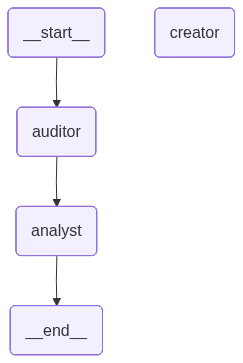

In [175]:
graph = StateGraph(State)

graph.add_node("auditor", auditor_agent)
graph.add_node("analyst", analyst_agent)
graph.add_node("creator", creator_agent)

graph.add_edge(START, "auditor")
graph.add_edge("auditor", "analyst")
graph.add_edge("analyst", END)

app = graph.compile()

app

### Testing the agent

In [176]:
test_state: State = {
    "user_profile": {
        "profile_description": "Machine Learning and AI concepts",
        "expertise": "Artificial Intelligence, Neural Networks, Machine Learning",
        "target_audience": "Engineers, Senior Developers and Researchers"
    },
    "auditor_output": None,
    "analyst_output": None,
    "creator_output": None
}

In [177]:
base_state = app.invoke(test_state)

weekly_plan = five_day_planner()
memory = WeekMemory()

weekly_posts = []

for plan in weekly_plan:
    adjusted_plan = apply_variation_control(plan, memory)

    post = creator_agent(base_state, adjusted_plan)

    memory.marked_used(
        adjusted_plan["hook_type"],
        adjusted_plan["structure"],
        adjusted_plan["focus"],
    )

    weekly_posts.append({
        "day": adjusted_plan["day"],
        "plan": adjusted_plan,
        "post": post,
    })

In [178]:
for item in weekly_posts:
    print(f"\n--- DAY {item['day']} POST ---\n")
    print(item['post']['creator_output'])


--- DAY 1 POST ---

**Can strategy learn anything from quantum mechanics?**  

In the same way that quantum physics reshaped our understanding of reality, it is beginning to reshape how we design machine‑learning systems.  
- **Superposition → Ensemble learning**: Just as a quantum state can be a weighted sum of basis states, an ensemble can combine diverse models to capture richer decision boundaries.  
- **Entanglement → Feature coupling**: Entangled particles exhibit correlations that cannot be explained classically. In ML, we can encode non‑local dependencies between features using graph neural networks or attention mechanisms, allowing models to “sense” distant relationships without explicit feature engineering.  
- **Uncertainty principle → Bayesian inference**: The trade‑off between position and momentum mirrors the bias‑variance trade‑off. Bayesian neural networks explicitly model uncertainty, providing calibrated predictions that are crucial for high‑stakes applications.  
- 